<a href="https://colab.research.google.com/github/atamadon/heartsound/blob/main/(COPY)EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display


from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_path = "/content/drive/MyDrive/HeartSound/"
project_path = "Classification/"
folder_path = os.path.join(base_path, project_path)
print(folder_path)
data_path = os.path.join(folder_path, "Data")
dataframes_train_test= os.path.join(folder_path, "Train-Test")


target_audios_class = os.listdir(data_path)

files = {}
for item in target_audios_class:
    if item != '.DS_Store':
        file_i = os.path.join(data_path, item)
        files[item] = os.listdir(file_i)
files.keys()

/content/drive/MyDrive/HeartSound/Classification/


dict_keys(['MVP_New', 'MS_New', 'MR_New', 'N_New', 'AS_New'])

In [ ]:
df = pd.DataFrame(list(zip(files.keys(), files.values())),
                  columns = ["data-name", "name"])
df = df.explode("name").reset_index(drop = True)

df["path"] = df.apply(lambda x: os.path.join(data_path, 
                                                  x["data-name"], 
                                                  x["name"]), 
                                                  axis = 1)

df["target"] = df["data-name"].apply(lambda x: x[:-4])
df.drop("data-name", inplace = True, axis = 1)
df.head()

,name,path,target
0,New_MVP_014.wav,/content/drive/MyDrive/HeartSound/Classificati...,MVP
1,New_MVP_005.wav,/content/drive/MyDrive/HeartSound/Classificati...,MVP
2,New_MVP_027.wav,/content/drive/MyDrive/HeartSound/Classificati...,MVP
3,New_MVP_016.wav,/content/drive/MyDrive/HeartSound/Classificati...,MVP
4,New_MVP_009.wav,/content/drive/MyDrive/HeartSound/Classificati...,MVP


In [ ]:
len(df)

1000

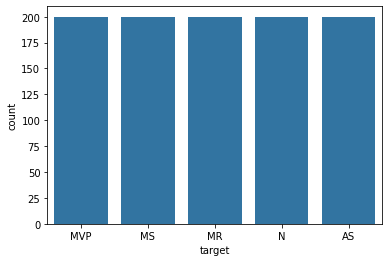

In [ ]:
sns.countplot(x = "target", data = df, color = "tab:blue");

# Some Basic Visualizations

## Denoising waveforms

### Spectral Gating using noisereduce
https://github.com/timsainb/noisereduce 

In [ ]:
!pip install noisereduce

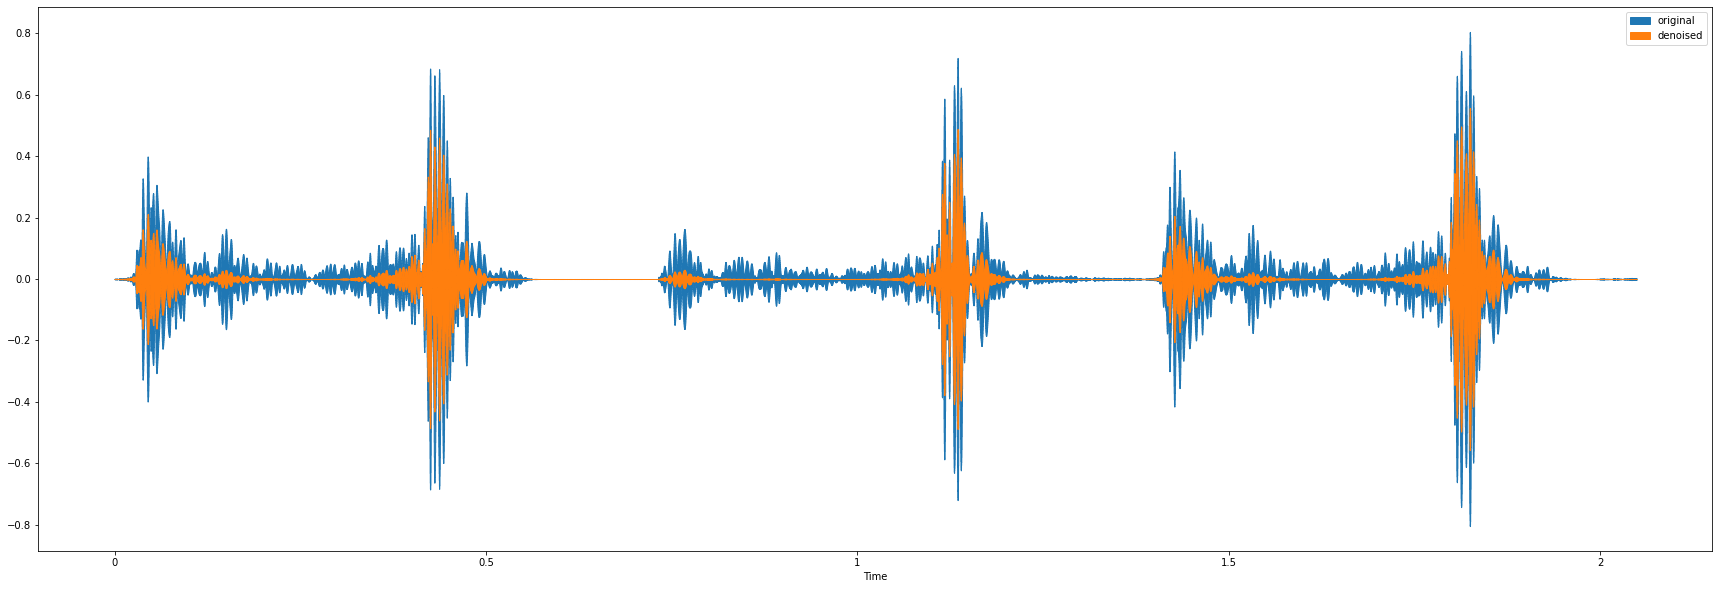

In [ ]:
import noisereduce as nr

example_id = 200
audio_path = df["path"].iloc[example_id]
audio_target = df["target"].iloc[example_id]

x, sr = librosa.load(audio_path)
x_reduced = nr.reduce_noise(y=x, sr=sr)

plt.figure(figsize=(30, 10))

librosa.display.waveshow(x, sr=sr, label = "original")
librosa.display.waveshow(x_reduced, sr=sr, label = "denoised")
plt.legend()

### Wavelet transform using SciPy
https://www.section.io/engineering-education/wavelet-transform-analysis-of-1d-signals-using-python/

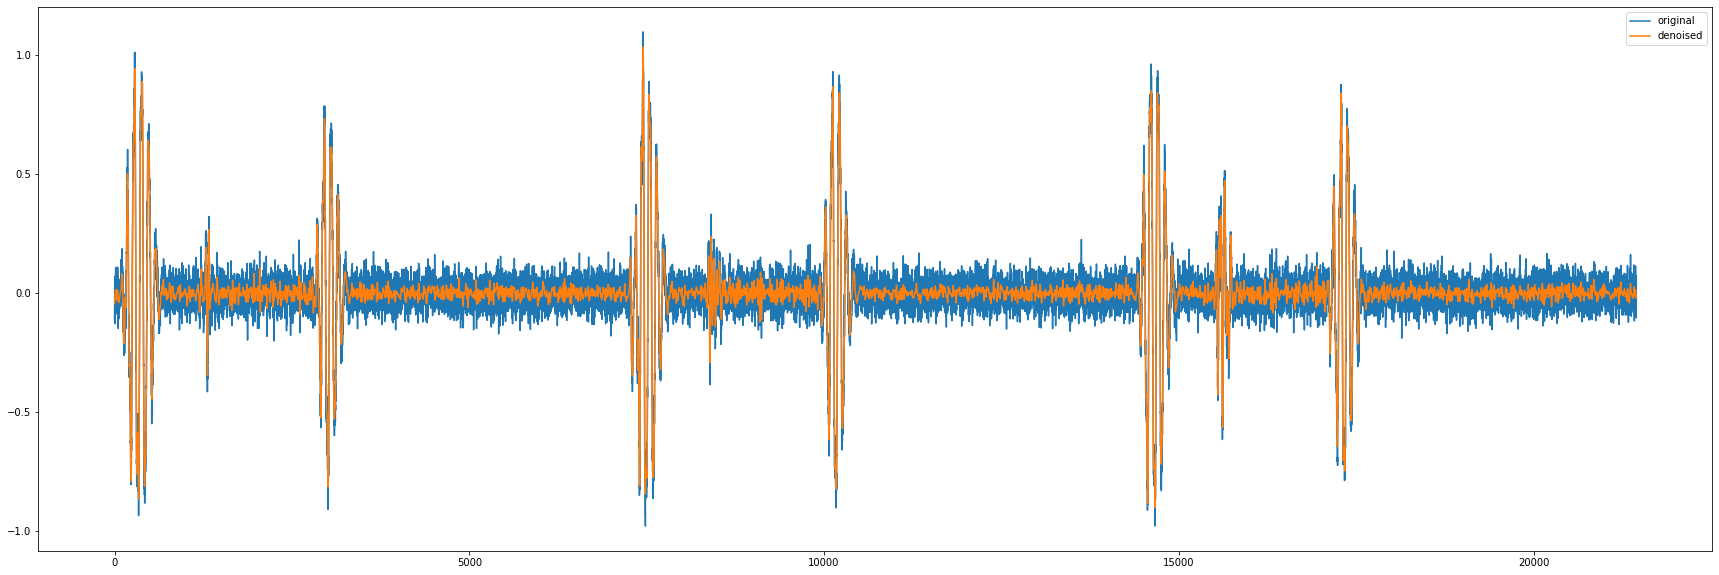

In [ ]:
#Using wavelet denoising
from scipy.io import wavfile
from skimage.restoration import denoise_wavelet

sr, x = wavfile.read(audio_path)
x = x/max(x)
#Adding noise
sigma = 0.05  # Noise variance
x = x + sigma * np.random.randn(x.size)

#Different denoising methods
#x_reduced = denoise_wavelet(x, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')
x_reduced = denoise_wavelet(x, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')

plt.figure(figsize=(30, 10))
plt.plot(x, label='original')
plt.plot(x_reduced, label='denoised')
plt.legend()
plt.show()

### High-Pass Filtering
https://www.kaggle.com/code/mauriciofigueiredo/methods-for-sound-noise-reduction?scriptVersionId=40324977&cellId=20


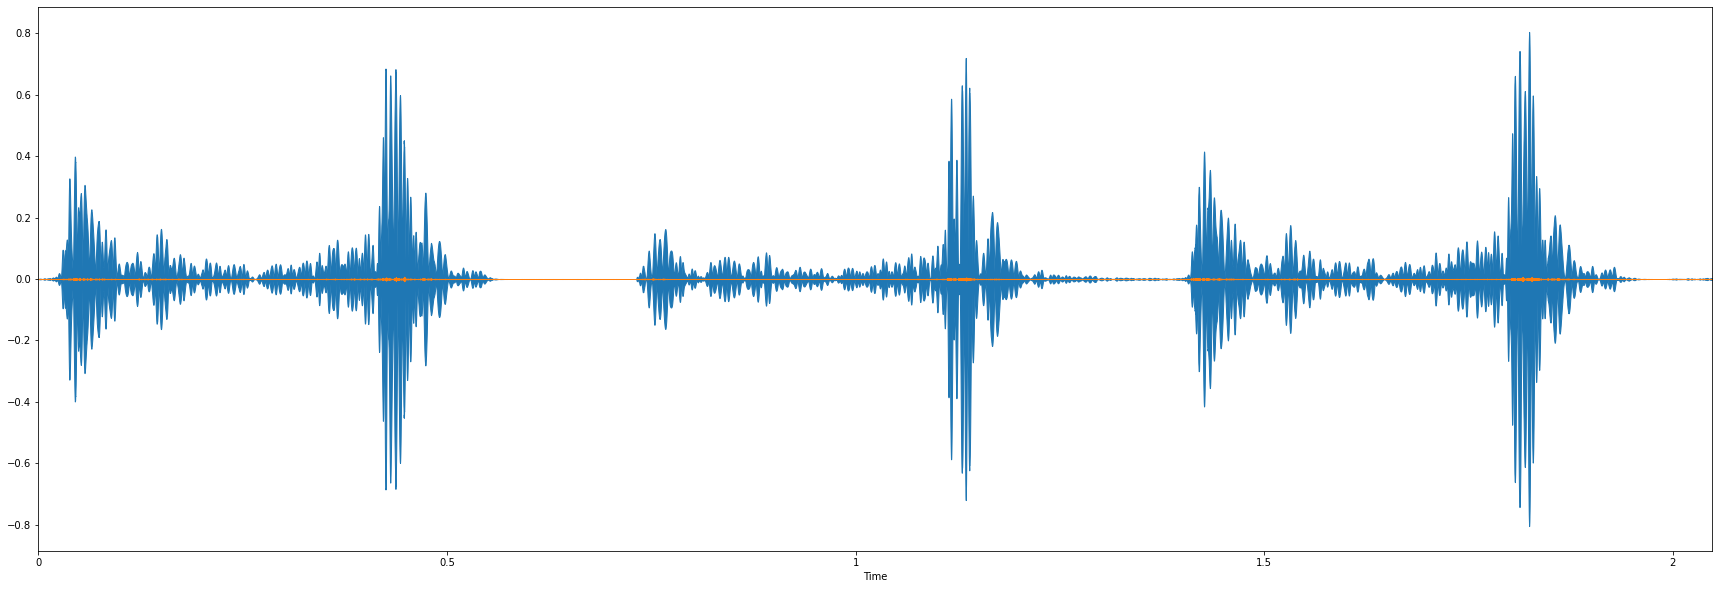

In [ ]:
from scipy import signal
import random

example_id = 200
audio_path = df["path"].iloc[example_id]
audio_target = df["target"].iloc[example_id]

y, sr = librosa.load(audio_path)

def f_high(y,sr):
    b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
    yf = signal.lfilter(b,a,y)
    return yf

yf = f_high(y, sr)

plt.figure(figsize=(30, 10))
librosa.display.waveplot(y,sr=sr, x_axis='time', label="original")
librosa.display.waveplot(yf,sr=sr, x_axis='time', label="filtered")

#librosa.display.waveplot(y2,sr=sr, x_axis='time')
#librosa.display.waveplot(yf2,sr=sr, x_axis='time')

## Spectrograms

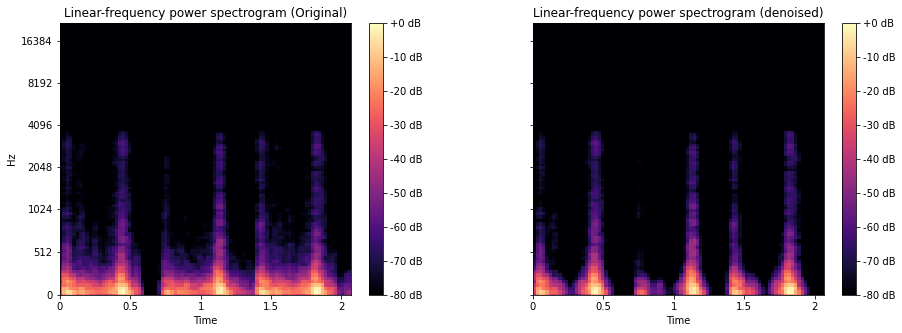

In [ ]:
figs, axes = plt.subplots(ncols = 2, figsize = (15, 5))
figs.subplots_adjust(hspace=0.4, wspace=0.3)

hl = 512 # number of samples per time-step in spectrogram
hi = 100 # Height of image
wi = 384 # Width of image
fmax = sr

S = librosa.feature.melspectrogram(y=x, sr=sr, 
                                   n_mels=hi, fmax=fmax,
                                   n_fft=2048, hop_length=hl)

S_reduced = librosa.feature.melspectrogram(y=x_reduced, sr=sr, 
                                           n_mels=hi, fmax=fmax,
                                           n_fft=2048, hop_length=hl)

S_dB = librosa.power_to_db(S, ref=np.max)
S_reduced_dB = librosa.power_to_db(S_reduced, ref=np.max)



img_1 = librosa.display.specshow(S_dB, x_axis='time', 
                         y_axis='mel', sr=sr, 
                         fmax=fmax, ax = axes[0])
axes[0].set(title='Linear-frequency power spectrogram (Original)')
axes[0].label_outer()
figs.colorbar(img_1, ax=axes[0], format="%+2.f dB");

img_2 = librosa.display.specshow(S_reduced_dB, x_axis='time', 
                         y_axis='mel', sr=sr, 
                         fmax=fmax, ax = axes[1])
axes[1].set(title='Linear-frequency power spectrogram (denoised)')
axes[1].label_outer()
figs.colorbar(img_2, ax=axes[1], format="%+2.f dB");

In [ ]:
def time(data):
    x, sr = librosa.load(data)
    return len(x)/sr

df["time"] = df["path"].apply(lambda x: time(x))
print("DONE")

DONE


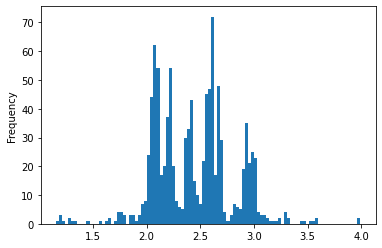

In [ ]:
df["time"].plot(kind = "hist", bins = 100);

In [ ]:
print(df["time"].max())
print(df["time"].min())

3.9928798185941043
1.1556462585034013


In [ ]:
data_path

'/Users/miladshirani/Documents/Heart-Sound-Classification-Projects/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/Data'

In [ ]:
df = df.sample(frac = 1)
df_path = os.path.join(dataframes_train_test, "df.csv")
df.to_csv(df_path)
print("DONE")

DONE


In [ ]:
y = df["target"]
X = df[["path", "name"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                   test_size = 0.2, 
                                                   random_state=42,
                                                   shuffle = True)

train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train_path = os.path.join(dataframes_train_test, "train.csv")
test_path = os.path.join(dataframes_train_test, "test.csv")

train.to_csv(train_path)
test.to_csv(test_path)
print("DONE")

DONE


# Mel Spectrogram

In [ ]:
def mel_spectrogram(target, data, path, sr = 16000):
    
    hl = 512 
    hi = 100 
    wi = 384 
    fmax = sr
    
    spectrogrmas_path = os.path.join(folder_path, "spectrograms")

    target_path = os.path.join(spectrogrmas_path, path, target)
    
    data_set = data[data["target"] == target]
    
    for i in tqdm(range(len(data_set))):
        
        audio_path = data_set["path"].iloc[i]
        audio_name = data_set["name"].iloc[i][:-4]
        
        x, _ = librosa.load(audio_path)
        x_reduced = nr.reduce_noise(y=x, sr=sr)
        
        S = librosa.feature.melspectrogram(y=x_reduced, sr=sr, n_mels=hi, 
                                           fmax=fmax, hop_length=hl)
        
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        img = librosa.display.specshow(S_dB, 
                                       x_axis='mel', 
                                       y_axis='time', 
                                       sr=sr, 
                                       fmax=fmax)
        
        
        mel_name = audio_name + ".png"
        plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        a = plt.gca()
        # set visibility of x-axis as False
        xax = a.axes.get_xaxis()
        xax = xax.set_visible(False)
  
        # set visibility of y-axis as False
        yax = a.axes.get_yaxis()
        yax = yax.set_visible(False)
        
        plt.ioff()
        plt.savefig(fname = os.path.join(target_path, mel_name),
                   dpi = 400,
                   bbox_inches = "tight",
                   pad_inches = 0)
        
        
        plt.close()
        
        
    print("DONE!") 

In [ ]:
targets = list(train["target"].unique())
targets

['MR', 'MVP', 'N', 'MS', 'AS']

In [ ]:
for item in targets:
    print(f"{item}\n")
    mel_spectrogram(target = item, data = train, path = "train", sr = 16000)

  0%|          | 0/160 [00:00<?, ?it/s]

MR



  0%|          | 0/160 [00:00<?, ?it/s]

DONE!
MVP



  0%|          | 0/160 [00:00<?, ?it/s]

DONE!
N



  0%|          | 0/160 [00:00<?, ?it/s]

DONE!
MS



  0%|          | 0/160 [00:00<?, ?it/s]

DONE!
AS



100%|██████████| 160/160 [01:01<00:00,  2.61it/s]

DONE!


In [ ]:
for item in targets:
    print(f"{item}\n")
    mel_spectrogram(target = item, data = test, path = "test", sr = 16000)

  0%|          | 0/40 [00:00<?, ?it/s]

MR



  0%|          | 0/40 [00:00<?, ?it/s]

DONE!
MVP



  0%|          | 0/40 [00:00<?, ?it/s]

DONE!
N



  0%|          | 0/40 [00:00<?, ?it/s]

DONE!
MS



  0%|          | 0/40 [00:00<?, ?it/s]

DONE!
AS



100%|██████████| 40/40 [00:15<00:00,  2.63it/s]

DONE!
